In [39]:
import numpy as np
import torch
import torch.nn as nn
from data_init import class_incremental, Data_Init
from model_config import MyModel_Config
from pytorch_pretrained_bert import BertConfig, BertTokenizer, BertModel, BertForMaskedLM
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt   #jupyter要matplotlib.pyplot
from torch.utils.data import DataLoader, Dataset, TensorDataset
import random
from train_eval import Model_Train
import re
from tqdm import *
import pandas as pd
from pandas import DataFrame
from torch.distributions import Dirichlet

In [40]:
'''调整随机数'''
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(5)

In [41]:
'''利用增量数据初始化处理数据集'''
train_incremental = class_incremental('./data/snips/train.tsv', 'tsv', 64, 7, 5, True, 9999999) #最后的500表示每个类的数据个数限制
train_original_datas, train_incremental_datas_list, train_original_labels, train_all_incremental_labels, labels, label_to_idx = train_incremental.prepare_for_incremental()
train_Joint_datasets = train_incremental.Joint_incremental()

#初始化验证集的原始类和增量类数据
dev_incremental = class_incremental('./data/snips/dev.tsv', 'tsv', 64, 7, 5, True, 999999, 'eval', labels, label_to_idx)
dev_original_datas, dev_incremental_datas_list, dev_original_labels, dev_all_incremental_labels = dev_incremental.prepare_for_incremental()
dev_Joint_datasets = dev_incremental.Joint_incremental()

#初始化测试集的原始类和增量类数据
test_incremental = class_incremental('./data/snips/test.tsv', 'tsv', 64, 7, 5, True, 9999999, 'eval', labels, label_to_idx)
test_original_datas, test_incremental_datas_list, test_original_labels, test_all_incremental_labels = test_incremental.prepare_for_incremental()
test_Joint_datasets = test_incremental.Joint_incremental()

In [5]:
'''定义训练模型'''
class Teachermodel(nn.Module):
    def __init__(self,config):
        super(Teachermodel,self).__init__()
        self.bert=BertModel.from_pretrained(config.bert_path)  
        for param in self.bert.parameters():
            param.requires_grad = True
 
        
        self.dropout=nn.Dropout(config.dropout)

        self.fc = nn.Linear(768, config.num_classes ) 


    def forward(self, tokens):

        encoder_out,pooled = self.bert(tokens,output_all_encoded_layers=False) 
     
        out=self.fc(encoder_out[:,0,:])
 
        out = self.dropout(out)
        
        return out


In [6]:
'''student模型'''
class Bert_student(nn.Module):
    def __init__(self,config):
        super(Bert_student,self).__init__()
        self.bert=BertModel.from_pretrained(config.bertmini_path)  
        for param in self.bert.parameters():
            param.requires_grad = True
        
        self.dropout=nn.Dropout(config.dropout)
        self.fc = nn.Linear(256, config.num_classes ) 


    def forward(self, tokens):

    
        encoder_out,pooled = self.bert(tokens,output_all_encoded_layers=False) 
        out=self.fc(encoder_out[:,0,:])
        out = self.dropout(out)
        
        return out

In [43]:
class Model_Train_ipynb(object):
    def __init__(self, isTPCIL=False): #
        #self.epochs = MyModel_Config.epochs #训练几个epochs
        self.device = 'cuda:0'
        self.isTPCIL = isTPCIL
        
    '''测试集和验证集的精度计算,用于全体验证集或测试集的精度计算
    model：要评估的模型
    datapath：输入字符串如'./data/snips/valid.csv'，表明要测试的验证集或测试集路径
    mode:输入字符串'csv'或'tsv' ，表明要测试的文件格式'''
    def my_eval(self, model, datapath, loss_func, mode, label_to_idx_train):
        device = self.device
        tensor_datas, labels_idx = Data_Init(datapath, 64, mode, 'eval', label_to_idx_train).datas_to_tensors()#输出都是tensor形式

        model = model.to(device)
        model.eval() #eval()将我们的模型置于评估模式，而不是训练模式。在这种情况下，评估模式关闭了训练中使用的dropout正则化。
        accuracy=0
        loss_sum=0
        with torch.no_grad():
            for idx, datas in enumerate(tensor_datas):
                tokens = datas[0].to(device)  #tokens输入到bert里得到[batch_size, seq_len, embedding_size]的embedding
                labels_idx = datas[1].to(device)
                
                if self.isTPCIL == False:
                    probs = model(tokens).squeeze()  #去除掉[batch_size, 1, len(classes)]中的1维度
                elif self.isTPCIL == True:
                    _, probs = model(tokens)  #去除掉[batch_size, 1, len(classes)]中的1维度
                    probs.squeeze()
                loss = loss_func(probs, labels_idx) #"host_softmax" not implemented for 'Long'错误出现，如果预测值和标签写反
                #虽然这里的probs没有经过softmax处理，但也可以用下面的这个argmax公式，因为softmax不会改变原本数值元素的大小排名
                accuracy += (labels_idx == torch.argmax(probs, dim=1)).sum()  #计算预测标签和真实标签相等的数量
                loss_sum+=loss.item() #计算所有样本/batch的loss
                
                last_size = len(datas[1])  #用于保存最后一个batch有多少数据

        accuracy = accuracy / (idx*tensor_datas.batch_size + last_size)
        accuracy = accuracy.item()
        model.train()#从eval模式回到train模式

        return accuracy, loss_sum
    
    '''由于增量学习要求对相应的增量类和原始类数据进行精度的计算，所以如果直接输入验证集路径进去，会导致计算所有类精度，所以这里输入变为直接输入数据
    model:要进行精度计算的模型
tensor_datas:验证集/测试集的经过Dataloader封装的数据
loss_function:用于计算验证集/测试集损失'''

    def eval_for_incremental(self, model, tensor_datas, loss_function):
        device = self.device
        model = model.to(device)

        accuracy=0
        loss_sum=0
    
        model.eval() #关闭模型dropout
        with torch.no_grad():
            idx = 0
            for idx, datas in enumerate(tensor_datas):
                tokens = datas[0].to(device)  #tokens输入到bert里得到[batch_size, seq_len, embedding_size]的embedding
                labels_idx = datas[1].to(device)
                
                if self.isTPCIL == False:
                    probs = model(tokens).squeeze()  #去除掉[batch_size, 1, len(classes)]中的1维度
                elif self.isTPCIL == True:
                    _, probs = model(tokens)  #去除掉[batch_size, 1, len(classes)]中的1维度
                    probs.squeeze()
                loss = loss_function(probs, labels_idx) #"host_softmax" not implemented for 'Long'错误出现，如果预测值和标签写反
            
                accuracy += (labels_idx == torch.argmax(probs, dim=1)).sum()  #计算预测标签和真实标签相等的数量
                loss_sum+=loss.item() #计算所有样本/batch的loss
                
                last_size = len(datas[1])  #用于保存最后一个batch有多少数据

        accuracy = float(accuracy) / (idx*tensor_datas.batch_size + last_size)

        model.train()#从eval模式回到train模式

        return accuracy, loss_sum
#用法：
#eval_for_incremental(model, tensor_datas, loss_function),用法在incremental_learning文件的类中

    def eval_for_embeddingKD(self, teacher_embed_model, student_revise, tensor_datas, loss_function):
        device = self.device
        teacher_embed_model = teacher_embed_model.to(device)
        student_revise = student_revise.to(device)

        accuracy=0
        loss_sum=0
    
        teacher_embed_model.eval() #关闭模型dropout
        student_revise.eval()
        with torch.no_grad():
            idx = 0
            for idx, datas in enumerate(tensor_datas):
                tokens = datas[0].to(device)  #tokens输入到bert里得到[batch_size, seq_len, embedding_size]的embedding
                labels_idx = datas[1].to(device)

                teacher_embed = teacher_embed_model(tokens)
                probs = student_revise(teacher_embed)

                loss = loss_function(probs, labels_idx) #"host_softmax" not implemented for 'Long'错误出现，如果预测值和标签写反
            
                accuracy += (labels_idx == torch.argmax(probs, dim=1)).sum()  #计算预测标签和真实标签相等的数量
                loss_sum+=loss.item() #计算所有样本/batch的loss
                
                last_size = len(datas[1])  #用于保存最后一个batch有多少数据

        accuracy = float(accuracy) / (idx*tensor_datas.batch_size + last_size)

        student_revise.train()#从eval模式回到train模式

        return accuracy, loss_sum


    '''参数：
    model：训练模型
    loss_func:损失函数
    optimizer:优化器
    epochs:迭代次数
    tensor_datas:要输入的Dataloader封装的数据，默认为MyModel_Config里面的数据
    datapath_eval: 如果等于'none'说明不对验证集或测试集进行每个batch训练后的精度和损失计算；如果等于验证集或测试集路径，则进行计算
    eval_mode：验证集或测试集的格式，为'csv'或'tsv'.
    label_to_idx_train:训练集的标签字典，只有当datapath_eval不为none时候才设置初值'''
    def my_train(self, model, loss_func, optimizer, epochs, tensor_datas, datapath_eval='none', eval_mode='csv', label_to_idx_train={}): #增加了需要自己输入的epochs
        device = self.device
        #epochs = self.epochs
        model.train()

        model = model.to(device)
        losses = [] #存放所有样本一个epoch的损失
        accuracies = []
        iter = [] #用于绘图的横坐标

        #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)#每一轮epoch学习率递减
        for epoch in tqdm(range(epochs)):
            
            '''对每个batch的训练'''
            for idx, datas in enumerate(tensor_datas):  #idx表示第几个batch，datas为[batch_size, tokens, label]的数据
                tokens = datas[0].to(device)
                labels = datas[1].to(device)
                #labels_one_hot = datas[1].to(device)  #one-hot形式标签，用于损失计算，[batch_size, labels_nums]
                #labels = torch.topk(labels_one_hot, 1)[1].view(-1,1)   #要计算精度，就需要非one-hot形式的标签，转化为(batch_size,1)形式的标签
        
                optimizer.zero_grad() #新batch训练时将梯度归0，防止梯度累积
                if self.isTPCIL == False:
                    probs = model(tokens).squeeze()  #去除掉[batch_size, 1, len(classes)]中的1维度
                elif self.isTPCIL == True:
                    _, probs = model(tokens)  #去除掉[batch_size, 1, len(classes)]中的1维度
                    probs.squeeze()
                loss = loss_func(probs, labels) #"host_softmax" not implemented for 'Long'错误出现，如果预测值和标签写反
                loss.backward()
                optimizer.step()
                #scheduler.step()#学习率递减
            accuracy_train, loss_sum = self.eval_for_incremental(model, tensor_datas, loss_func)
    
            if datapath_eval != 'none': 
                if label_to_idx_train == {}:
                    raise ValueError("要输出测试集精度模式下需要输入训练集对应的标签字典")
                accuracy_eval, loss_eval = self.my_eval(model, datapath_eval, loss_func, eval_mode, label_to_idx_train)
                print('第'+str(epoch)+'的验证集失为：'+str(loss_eval))
                print('第'+str(epoch)+'的验证集精度为：'+str(accuracy_eval))
            
            accuracies.append(accuracy_train) #accuracy上的数据在cuda上，需要放到cpu上才能作图，而loss.item()已经加到cpu上了
            losses.append(loss_sum)
            iter.append(epoch)
            #print("the loss of  training data "+ str(epoch) + "  is-----------" + str(loss_sum))
            #print("the accuracy of training data   "+ str(epoch) + "  is-----------" + str(accuracy_train))
    
        #plt.figure(1)
        #plt.title("loss of epoch per————"+str(loss_func)+ ","+ str(epochs)+ "epochs")
        #plt.xlabel("loss per epoch")
        #plt.ylabel("LOSS")
        #plt.plot(iter, losses)

        #plt.figure(2)
        #plt.title("accuracy of epoch per————"+str(accuracy_train)+ ","+ str(epochs)+ "epochs")
        #plt.xlabel("accuracy per epoch")
        #plt.ylabel("ACCURACY")
        #plt.plot(iter, accuracies)

        #plt.show()
        return accuracies, losses

In [10]:
'''利用原始数据训练并保存Teacher model'''
print('*******************原始数据训练Teacher model**********************')
teacher_model = Teachermodel(MyModel_Config(train_original_labels))
optimizer = torch.optim.AdamW(teacher_model.parameters(), lr=1e-5)
loss_fuc = nn.CrossEntropyLoss()

'''训练模型，得到精度'''
accuracy_train, loss_train = Model_Train_ipynb().my_train(teacher_model, loss_fuc, optimizer, 10, train_original_datas)
accuracy_dev, loss_dev = Model_Train_ipynb().eval_for_incremental(teacher_model, dev_original_datas, loss_fuc)
accuracy_test, loss_test = Model_Train_ipynb().eval_for_incremental(teacher_model, test_original_datas, loss_fuc)
print('训练集精度变化'+str(accuracy_train))
print('验证集最终精度'+str(accuracy_dev))
print('测试集最终精度'+str(accuracy_test))

*******************原始数据训练Teacher model**********************


100%|██████████| 10/10 [09:13<00:00, 55.37s/it]


训练集精度变化[0.9859068627450981, 0.9905790441176471, 0.9931832107843137, 0.9954810049019608, 0.9931832107843137, 0.9967830882352942, 0.9983915441176471, 0.9983149509803921, 0.9990042892156863, 0.9993872549019608]
验证集最终精度0.9875
测试集最终精度0.98125


In [11]:
'''利用原始数据训练并保存student model'''
print('*******************原始数据训练Student model**********************')
student_model = Bert_student(MyModel_Config(train_original_labels))
optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-5)
loss_fuc = nn.CrossEntropyLoss()

'''训练模型，得到精度'''
accuracy_train, loss_train = Model_Train_ipynb().my_train(student_model, loss_fuc, optimizer, 10, train_original_datas)
accuracy_dev, loss_dev = Model_Train_ipynb().eval_for_incremental(student_model, dev_original_datas, loss_fuc)
accuracy_test, loss_test = Model_Train_ipynb().eval_for_incremental(student_model, test_original_datas, loss_fuc)
print('训练集精度变化'+str(accuracy_train))
print('验证集最终精度'+str(accuracy_dev))
print('测试集最终精度'+str(accuracy_test))


*******************原始数据训练Student model**********************


100%|██████████| 10/10 [01:59<00:00, 11.93s/it]


训练集精度变化[0.934359681372549, 0.9654564950980392, 0.9760263480392157, 0.9816176470588235, 0.9832261029411765, 0.9862132352941176, 0.9872855392156863, 0.9892769607843137, 0.9896599264705882, 0.9919577205882353]
验证集最终精度0.9859375
测试集最终精度0.978125


In [45]:
'''teacher模型,embedding层的参数不可修改'''
class Teachermodel_revise(nn.Module):
    def __init__(self,teacher_model, device):
        super(Teachermodel_revise,self).__init__()
        
        self.device = device

        self.teacher_model_embedding = teacher_model.bert.embeddings
        for param in self.teacher_model_embedding.parameters():    
            param.requires_grad = False

        self.teacher_model_encoder = teacher_model.bert.encoder
        for param in self.teacher_model_encoder.parameters():    
            param.requires_grad = True

        self.teacher_model_remain = teacher_model.bert.pooler   #这里由于nn.Sequential只能接收单独输入，所以encoder需要两个输入[embedding, attention_mask]，但是sequential不能接受两个收入，就会报错

        for param in self.teacher_model_remain.parameters():    
            param.requires_grad = True   #冻结teahcer model所有剩余层的参数，不进行梯度更新

        self.teacher_model_classifier = nn.Sequential(teacher_model.dropout,
                                                      teacher_model.fc)
        for param in self.teacher_model_classifier.parameters():
            param.requires_grad = True


    def forward(self, tokens):
        out = self.teacher_model_embedding(tokens)
        
        out = self.teacher_model_encoder(out, attention_mask=torch.tensor([1]).to(self.device)) #输入(batch_size, seq_len, embedding_size)的tokens embedding, 输出(batch_size, num_classes)的out
        pooled_output = self.teacher_model_remain(out[-1])  #out[-1]代表最后一个encoder的输出,pooler层直接输出[CLS]的

        probs = self.teacher_model_classifier(pooled_output)
        
        return probs 
        

In [46]:
'''利用原始数据训练并保存Teacher model'''
print('*******************原始数据训练Teacher model**********************')
teacher_model = Teachermodel(MyModel_Config(train_original_labels))
teacher_model_reviese = Teachermodel_revise(teacher_model, 'cuda:0')
optimizer = torch.optim.AdamW(teacher_model.parameters(), lr=1e-5)
loss_fuc = nn.CrossEntropyLoss()

'''训练模型，得到精度'''
accuracy_train, loss_train = Model_Train_ipynb().my_train(teacher_model_reviese, loss_fuc, optimizer, 10, train_original_datas)
accuracy_dev, loss_dev = Model_Train_ipynb().eval_for_incremental(teacher_model_reviese, dev_original_datas, loss_fuc)
accuracy_test, loss_test = Model_Train_ipynb().eval_for_incremental(teacher_model_reviese, test_original_datas, loss_fuc)
print('训练集精度变化'+str(accuracy_train))
print('验证集最终精度'+str(accuracy_dev))
print('测试集最终精度'+str(accuracy_test))

*******************原始数据训练Teacher model**********************


 30%|███       | 3/10 [03:06<07:16, 62.31s/it]


KeyboardInterrupt: 

: 

In [16]:
'''student模型,embedding层的参数不可修改'''
class Studentmodel_revise(nn.Module):
    def __init__(self,student_model, device):
        super(Studentmodel_revise,self).__init__()
        
        self.device = device

        self.student_model_embedding = student_model.bert.embeddings
        for param in self.student_model_embedding.parameters():    
            param.requires_grad = False

        self.student_model_encoder = student_model.bert.encoder
        for param in self.student_model_encoder.parameters():    
            param.requires_grad = True

        self.student_model_remain = student_model.bert.pooler   #这里由于nn.Sequential只能接收单独输入，所以encoder需要两个输入[embedding, attention_mask]，但是sequential不能接受两个收入，就会报错

        for param in self.student_model_remain.parameters():    
            param.requires_grad = True   #冻结teahcer model所有剩余层的参数，不进行梯度更新

        self.student_model_classifier = nn.Sequential(student_model.dropout,
                                                      student_model.fc)
        for param in self.student_model_classifier.parameters():
            param.requires_grad = True


    def forward(self, tokens):
        out = self.student_model_embedding(tokens)
        
        out = self.student_model_encoder(out, attention_mask=torch.tensor([1]).to(self.device)) #输入(batch_size, seq_len, embedding_size)的tokens embedding, 输出(batch_size, num_classes)的out
        pooled_output = self.student_model_remain(out[-1])  #out[-1]代表最后一个encoder的输出,pooler层直接输出[CLS]的

        probs = self.student_model_classifier(pooled_output)
        
        return probs 
        

In [13]:
'''利用原始数据训练并保存student model'''
print('*******************原始数据训练Student model**********************')
student_model = Bert_student(MyModel_Config(train_original_labels))
student_model_reviese = Studentmodel_revise(student_model, 'cuda:0')
optimizer = torch.optim.AdamW(student_model_reviese.parameters(), lr=1e-5)
loss_fuc = nn.CrossEntropyLoss()

'''训练模型，得到精度'''
accuracy_train, loss_train = Model_Train_ipynb().my_train(student_model_reviese, loss_fuc, optimizer, 10, train_original_datas)
accuracy_dev, loss_dev = Model_Train_ipynb().eval_for_incremental(student_model_reviese, dev_original_datas, loss_fuc)
accuracy_test, loss_test = Model_Train_ipynb().eval_for_incremental(student_model_reviese, test_original_datas, loss_fuc)
print('训练集精度变化'+str(accuracy_train))
print('验证集最终精度'+str(accuracy_dev))
print('测试集最终精度'+str(accuracy_test))


*******************原始数据训练Student model**********************


100%|██████████| 10/10 [01:53<00:00, 11.33s/it]


训练集精度变化[0.9080116421568627, 0.9607077205882353, 0.9668351715686274, 0.9743412990196079, 0.9822303921568627, 0.9859068627450981, 0.9880514705882353, 0.9881280637254902, 0.9901960784313726, 0.9916513480392157]
验证集最终精度0.984375
测试集最终精度0.9796875


In [17]:
last_layer_weight = teacher_model.fc.weight.detach().to('cpu')  #去除梯度
concent_params = torch.zeros([last_layer_weight.shape[0], last_layer_weight.shape[0]])
for i in range(len(last_layer_weight)):
    for j in range(len(last_layer_weight)):
        param = torch.matmul(last_layer_weight[i],last_layer_weight[j])
        param = param / (torch.norm(last_layer_weight[i]) * torch.norm(last_layer_weight[j]))  #计算最后一层权重的关系
        concent_params[i][j] = param
        
    max_val = torch.max(concent_params[i])
    min_val = torch.min(concent_params[i])
    concent_params[i] = (concent_params[i] - min_val + 1e-7) / (max_val-min_val)   #加上1e-7防止有0存在
    
labels = train_original_labels #绘图用到的标签

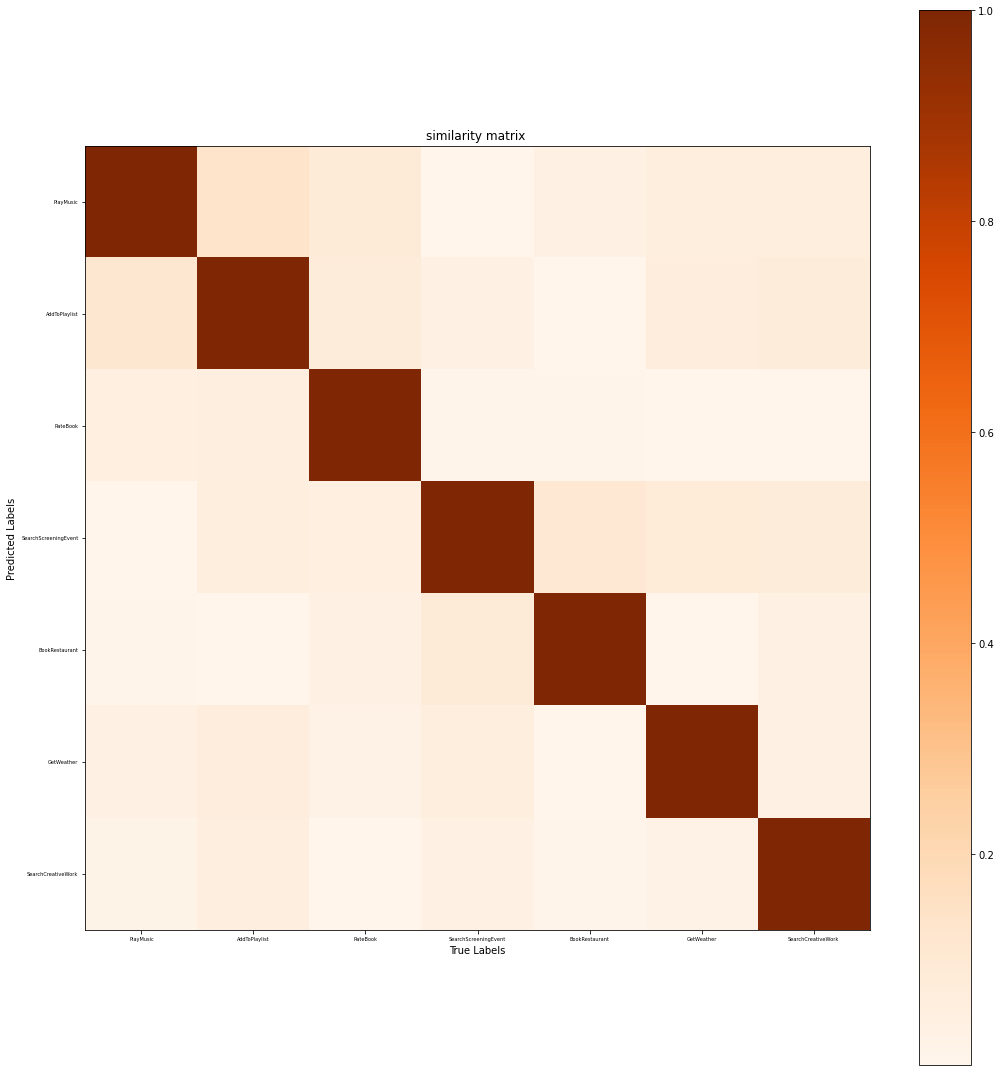

In [18]:
'''相似度矩阵绘制'''
def similar_matrix_plot(concent_params, num_classes, labels):#绘制混淆矩阵
    matrix = concent_params.numpy()  #先放在numpy上才能作图
    plt.figure(figsize=(15,15))  #设置画布大小
    plt.imshow(matrix, cmap=plt.cm.Oranges)
  
    # 设置x轴坐标label
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, labels,fontsize=5)
    plt.yticks(tick_marks, labels,fontsize=5)
        # 显示colorbar
    plt.colorbar()
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Labels')
    plt.title('similarity matrix ')

    plt.tight_layout()
    plt.show()

similar_matrix_plot(concent_params, len(train_original_labels), labels)

In [24]:
'''通过teacher model和direclet samples训练生成DI的embeddings，用于蒸馏student model
DIemb_Gen_model:用于生成DI embedding的模型
dir_samples:用Dataloader包装的迪利克雷分布及其标签
opitmizer:用于优化DIemb_Gen_model
loss_func:KL散度
loss_func2:交叉熵
'''
def train_DI_Embeddings_gen(DIemb_Gen_model, DIemb_datasets, optimizer, loss_func, loss_func2, temper=10, error=0.3, batch_size=64, max_iter=True):
    device = 'cuda:0'
    loss_num=999
    DIemb_Gen_model = DIemb_Gen_model.to(device)
    embeddings = torch.tensor([]).to(device)  #用于存放最终生成的tokens embeddings
    embedding_labels = torch.tensor([]).to(device)

    for _, data in tqdm(enumerate(DIemb_datasets)):
            
        dir_samples = data[0].to(device)
        labels = data[1].long().to(device)

        z = torch.randn(batch_size,30,768).to(device)   #噪声为[batch_size, seq_len, embedding_size]形式输入到改动了embedding层后的teacher model

        tokensemb_gens = torch.tensor([]).to(device)
        emb_probs = torch.tensor([]).to(device)
        losses = torch.tensor([]) #保存对应的损失
        count = 0
        loss_num = 999
        while loss_num > error:  
            
            if max_iter == True and count>=300:  #是否设置最大迭代次数1200
                break
            
            optimizer.zero_grad()
            probs, emb_gens = DIemb_Gen_model(z)
            
            loss = loss_func(F.log_softmax(probs / temper, dim=1), dir_samples) + 0.6*loss_func2(probs, labels)

            loss_num = loss.item()
            
            loss.requires_grad_(True) #这里应该是因为如果将最后一层的模型参数梯度关闭，则计算出来的loss也没有梯度，不能追踪，所以要将loss的梯度设置为True
            loss.backward()
            optimizer.step()
            
            loss_num = loss.item()
            count += 1
            
            if count%2==0:
                tokensemb_gens = torch.cat([tokensemb_gens, emb_gens], dim=0)
                emb_probs = torch.cat([emb_probs, probs], dim=0)
                losses = torch.cat([losses, torch.tensor([loss_num])])
                #print(loss_num)
        #print('训练过程中teacher model的预测情况'+str(torch.argmax(probs)))
            
        if max_iter == True and len(tokensemb_gens) > 0:
            num = torch.argmin(losses).item()
            tokensemb_gen = tokensemb_gens[num*batch_size : (num+1)*batch_size]  #选择loss最小的
            emb_probs_batch = emb_probs[num*batch_size : (num+1)*batch_size]
        
        embeddings = torch.cat([embeddings, tokensemb_gen], dim=0)
        emb_label = torch.argmax(emb_probs_batch, dim=1)  #找到对应的标签
        embedding_labels = torch.cat([embedding_labels, emb_label], dim=0)
            
    return embeddings.detach(), embedding_labels.detach()

In [25]:
'''用于生成DI_embedding数据印象的模型'''
class DIemb_Gen_model(nn.Module):
    def __init__(self, teacher_model, device):
        super(DIemb_Gen_model,self).__init__()
        self.device = device
        self.fc1 = nn.Linear(768,1024)
        self.fc2 = nn.Linear(1024,768)       #用于训练网络生成符合条件的噪声
        
        self.teacher_model_encoder = teacher_model.bert.encoder
        for param in self.teacher_model_encoder.parameters():    
            param.requires_grad = False

        self.teacher_model_remain = teacher_model.bert.pooler   #这里由于nn.Sequential只能接收单独输入，所以encoder需要两个输入[embedding, attention_mask]，但是sequential不能接受两个收入，就会报错

        for param in self.teacher_model_remain.parameters():    
            param.requires_grad = False   #冻结teahcer model所有剩余层的参数，不进行梯度更新

        self.teacher_model_classifier = nn.Sequential(teacher_model.dropout,
                                                      teacher_model.fc)
        for param in self.teacher_model_classifier.parameters():
            param.requires_grad = False


    def forward(self, z):
        out = self.fc1(z)
        out = torch.relu(out)
        emb_gen = self.fc2(out)
        self.teacher_model_encoder.eval()
        self.teacher_model_remain.eval()
        
        out = self.teacher_model_encoder(emb_gen, attention_mask=torch.tensor([1]).to(self.device)) #输入(batch_size, seq_len, embedding_size)的tokens embedding, 输出(batch_size, num_classes)的out
        pooled_output = self.teacher_model_remain(out[-1])  #out[-1]代表最后一个encoder的输出,pooler层直接输出[CLS]的

        probs = self.teacher_model_classifier(pooled_output)   
        
        return probs, emb_gen

In [26]:
'''生成并打包迪利克雷分布采样进入Dataloader中,并且定义模型和损失函数,优化器'''
dir_samples = torch.tensor([])
dir_labels = torch.tensor([])
DIemb_num = 10000
for i in tqdm(range(len(train_original_labels))):  #标签的idx刚好和train_original_labels的下标顺序对应

    for k in [1,5]:  #每种β生成1/2的数据
        m = Dirichlet(k*concent_params[i])  #采样每个类的数据
        
        for j in range(int(DIemb_num/len(train_original_labels)/2)):

            x = m.sample().view(1,-1)

            dir_samples = torch.cat([dir_samples, x], dim=0)
            dir_labels = torch.cat([dir_labels,torch.tensor([i]).long()], dim=0)
            
dirsample_datasets = TensorDataset(dir_samples, dir_labels)
dirsample_datasets = DataLoader(dirsample_datasets, batch_size=64, shuffle=True, drop_last=True, num_workers=2)

model = DIemb_Gen_model(teacher_model, 'cuda:0')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_func = nn.KLDivLoss()
loss_func2 = nn.CrossEntropyLoss()

100%|██████████| 7/7 [00:09<00:00,  1.40s/it]


In [272]:
'''
student_model = Bert_student(MyModel_Config(train_original_labels))
encoder_layer = student_model.bert.encoder       #独立拿出encoder层
encoder_layer
emb_layer = student_model.bert.embeddings        #独立拿出embedding层
emb_layer
x = torch.randn(128,30,300)
x = torch.argmax(x, dim=2).long()                  #随机生成tokens
x.shape
tokens_embedding = emb_layer(x)                 #将input_ids(tokens)输入到embedding层
tokens_embedding.shape
m = encoder_layer(tokens_embedding, attention_mask=torch.tensor([1]))    #将tokens embedding和attention mask输入到encoder层中
len(m)   #这里由于encoder输出的是所有encoder的hidden embedding， 所以要取最后一个encoder的hidden embeddidng
m[3]
'''

'''   
x = torch.randn(128,30,768)
teacher_model = teacher_model.to('cpu')
teacher_model_encoder = teacher_model.bert.encoder
out = teacher_model_encoder(x, attention_mask=torch.tensor([1]))[-1]
teacher_model_remain = nn.Sequential(      #这里由于nn.Sequential只能接收单独输入，所以encoder需要两个输入[embedding, attention_mask]，但是sequential不能接受两个收入，就会报错
                        teacher_model.bert.pooler,
                        teacher_model.dropout,
                        teacher_model.fc)    #除去teacher model的embedding层的剩余层
teacher_model_remain(out)
'''

"   \nx = torch.randn(128,30,768)\nteacher_model = teacher_model.to('cpu')\nteacher_model_encoder = teacher_model.bert.encoder\nout = teacher_model_encoder(x, attention_mask=torch.tensor([1]))[-1]\nteacher_model_remain = nn.Sequential(      #这里由于nn.Sequential只能接收单独输入，所以encoder需要两个输入[embedding, attention_mask]，但是sequential不能接受两个收入，就会报错\n                        teacher_model.bert.pooler,\n                        teacher_model.dropout,\n                        teacher_model.fc)    #除去teacher model的embedding层的剩余层\nteacher_model_remain(out)\n"

https://zhuanlan.zhihu.com/p/414511434    bert encoder中输入两个，一个是tokens embeddding，另外一个是attention mask 如果为1代表要被attention，如果为0代表是padding的，要被mask掉

白菜，牙刷，奶瓶，草，玉米，稻草，钉耙，红卷，白团，火把，钳子，萝卜，木桩3


In [27]:
'''训练生成tokens embedding'''
embeddings_gen, embedding_labels = train_DI_Embeddings_gen(model, dirsample_datasets, optimizer, loss_func, loss_func2)
embedding_gen = embeddings_gen.to('cpu')
embedding_labels = embedding_labels.to('cpu')

0it [00:00, ?it/s]/root/deepo/LYL/anaconda/ls/envs/csuse/lib/python3.7/site-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
156it [1:30:36, 34.85s/it]


In [28]:
DIemb_datasets = TensorDataset(embedding_gen, embedding_labels)   #这里不用detach接下来就不能训练
DIemb_datasets = DataLoader(DIemb_datasets, batch_size=128, shuffle=True, drop_last=True)

In [29]:
labels = torch.tensor([])
for i, data in enumerate(DIemb_datasets):
    labels = torch.cat([labels, data[1]], dim=0)


In [30]:
'''标签更加均衡'''
label_idx = {}
for i in range(len(train_original_labels)):
    label_idx[i] = 0

for i in range(len(labels)):
    label_idx[labels[i].item()] += 1
print(label_idx)

{0: 1426, 1: 1425, 2: 1427, 3: 1427, 4: 1427, 5: 1425, 6: 1427}


In [349]:
'''读取OOD的wiki103数据'''
import os
def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, encoding='utf-8') as f:
        lines = f.readlines()
    # 大写字母转换为小写字母
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

paragraphs = _read_wiki('./wiki103')

'''将读取的wiki数据tokenize'''
tokenizer = BertTokenizer.from_pretrained('./bert-pretrained')
tokens = []
datas_size = len(paragraphs)
for l in tqdm(range(datas_size)):
    for k in range(len(paragraphs[l])):
        text = paragraphs[l][k]
        text = tokenizer.tokenize(text)
        token = tokenizer.convert_tokens_to_ids(text)
        tokens.append(token)

100%|██████████| 760542/760542 [20:51<00:00, 607.93it/s]


In [ ]:
ood_num = 1000
ood_datas = []
temp = [[] for i in range(len(tokens))] #这样防止temp和tokens地址相同
for i in range(len(tokens)):
    temp[i] = tokens[i]
for i in range(ood_num):  #Bert最长读512最少读2长度的tokens,所以要处理
    if len(temp[i]) <98 and len(temp[i])>2:
        while len(temp[i])<100:
            temp[i].append(0)  #padding到100
        ood_datas.append(temp[i])
        
print(len(ood_datas))

In [171]:
'''训练一个转移模型，使得teacher model 768的embedding可以迁移到student model 不一样的embedding空间中'''
'''embed_transfer_model:'''
class embed_transfer_model(nn.Module):
    def __init__(self, teahcer_dim, student_dim):
        super(embed_transfer_model,self).__init__()
        
        self.teacher_dim = teahcer_dim
        self.student_dim = student_dim

        self.transfer_model = nn.Sequential(nn.Linear(self.teacher_dim, 1024), nn.Tanh(), nn.Linear(1024, self.student_dim))


    def forward(self, tokens_embedding):
        
        out = self.transfer_model(tokens_embedding)
        
        return out 


def embed_transfer_train(teacher_embed_model, student_embed_model, transfer_model, ood_datas, optimizer, loss_func, temper=10):
    device = 'cuda:0'
    teacher_embed_model.eval()
    student_embed_model.eval()
    transfer_model.train()
    teacher_embed_model = teacher_embed_model.to(device)
    student_embed_model = student_embed_model.to(device)
    transfer_model = transfer_model.to(device)

    for i, data in enumerate(ood_datas):
        ood_tokens = data[0].to(device)
        with torch.no_grad:
            teacher_embed = teacher_embed_model(ood_tokens)
            student_embed = student_embed_model(ood_tokens)
        
        optimizer.zero_grad()
        teacher_transfer = transfer_model(teacher_embed)
        loss = loss_func(torch.log(teacher_transfer / temper, dim=1), student_embed / temper, dim=1)  #KL散度
        
        loss_num = loss.item() 
        loss.backward()
        optimizer.step()
    


In [36]:
'''尝试2019DI的zero-shot蒸馏student模型的训练函数
参数：
teacher_model:被提取的模型
student_model:要提取出的模型
datas:DI生成的数据，用Dataloader封装
optimizer:优化器，只优化student_model的参数
loss_func:采用KL散度，或是MSE等保持teacher和student的softmax输出的相似性
temper:KL散度的温度系数,不能设置太高，经过实验探究，设置到4左右效果最好
'''
def train_KD_student(teacher_model_embedding, teacher_model, student_model, datas, optimizer, loss_func, loss_func2, temper, epochs , train_original_datas, dev_original_datas, test_original_datas):
    device = 'cuda:0'
    teacher_model = teacher_model.to(device)
    student_model = student_model.to(device)
    teacher_model_embedding = teacher_model_embedding.to(device)
    teacher_model_embedding.eval()
    teacher_model.eval()
    student_model.train()
    
    losses = [] #存放所有样本一个epoch的损失
    accuracies = []
    
    max_acc_fin = 0 #记录最终最大精度测试集组并输出
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)#每一轮epoch学习率递减
    for epoch in tqdm(range(epochs)):
        max_acc_test = 0
        '''对每个batch的训练'''
        for idx, data in enumerate(datas):  #idx表示第几个batch，datas为[batch_size, tokens, label]的数据
            student_model.train()
            tokens_embedding = data[0].to(device)
            #labels = data[1].to(device)
        
            optimizer.zero_grad() #新batch训练时将梯度归0，防止梯度累积
            
        
            probs_teacher = teacher_model(tokens_embedding)
            
            probs_student = student_model(tokens_embedding)
            
            loss = loss_func(F.log_softmax(probs_student / temper, dim=1), F.softmax(probs_teacher / temper, dim=1))
            #loss = 0.8*loss_func(F.log_softmax(probs_student / temper, dim=1), F.softmax(probs_teacher / temper, dim=1)) + 0.2*loss_func2(probs_student, labels)
            loss.backward(retain_graph=True)  #这里不用loss.requires_grad_(True)的原因是优化器优化的参数中间步骤不包括梯度不动的teacher_model
            optimizer.step()
            #scheduler.step()#学习率递减
            print(loss.item())
            
            student_model.eval()
            accuracy_test, _ = Model_Train_ipynb().eval_for_embeddingKD(teacher_model_embedding, student_model, test_original_datas, loss_func2)
            
            if max_acc_test<accuracy_test:
                max_acc_test = accuracy_test
                accuracy_train, _ = Model_Train_ipynb().eval_for_embeddingKD(teacher_model_embedding, student_model, train_original_datas, loss_func2)
                accuracy_dev, _ = Model_Train_ipynb().eval_for_embeddingKD(teacher_model_embedding, student_model, dev_original_datas, loss_func2)
        
        print('训练集精度'+str(accuracy_train))
        print('验证集精度'+str(accuracy_dev))
        print('测试集精度'+str(max_acc_test))
        
        if max_acc_fin<max_acc_test:
            max_acc_fin = max_acc_test
            accuracy_train_fin = accuracy_train
            accuracy_dev_fin = accuracy_dev

        student_model.train()
    
    print('训练集最终精度'+str(accuracy_train_fin))
    print('验证集最终精度'+str(accuracy_dev_fin))
    print('测试集最终精度'+str(max_acc_fin))
               

In [37]:
'''定义用于蒸馏的模型'''
class Teachermodel_revise(nn.Module):
    def __init__(self,teacher_model, device):
        super(Teachermodel_revise,self).__init__()

        self.device = device

        self.teacher_model_encoder = teacher_model.bert.encoder
        for param in self.teacher_model_encoder.parameters():    
            param.requires_grad = False

        self.teacher_model_remain = teacher_model.bert.pooler   #这里由于nn.Sequential只能接收单独输入，所以encoder需要两个输入[embedding, attention_mask]，但是sequential不能接受两个收入，就会报错

        for param in self.teacher_model_remain.parameters():    
            param.requires_grad = False   #冻结teahcer model所有剩余层的参数，不进行梯度更新

        self.teacher_model_classifier = nn.Sequential(teacher_model.dropout,
                                                      teacher_model.fc)
        for param in self.teacher_model_classifier.parameters():
            param.requires_grad = False


    def forward(self, tokens_embedding):
        
        out = self.teacher_model_encoder(tokens_embedding, attention_mask=torch.tensor([1]).to(self.device)) #输入(batch_size, seq_len, embedding_size)的tokens embedding, 输出(batch_size, num_classes)的out
        pooled_output = self.teacher_model_remain(out[-1])  #out[-1]代表最后一个encoder的输出,pooler层直接输出[CLS]的

        probs = self.teacher_model_classifier(pooled_output) 
        
        return probs



'''student模型'''
class Studentmodel_revise(nn.Module):
    def __init__(self,student_model, device, teacher_dim=768, student_dim=768):
        super(Studentmodel_revise,self).__init__()
        
        self.device = device

        #self.fc1 = nn.Linear(teacher_dim, 1024)
        #self.fc2 = nn.Linear(1024, student_dim)

        self.student_model_encoder = student_model.bert.encoder
        for param in self.student_model_encoder.parameters():    
            param.requires_grad = True

        self.student_model_remain = student_model.bert.pooler   #这里由于nn.Sequential只能接收单独输入，所以encoder需要两个输入[embedding, attention_mask]，但是sequential不能接受两个收入，就会报错

        for param in self.student_model_remain.parameters():    
            param.requires_grad = True   #冻结teahcer model所有剩余层的参数，不进行梯度更新

        self.student_model_classifier = nn.Sequential(student_model.dropout,
                                                      student_model.fc)
        for param in self.student_model_classifier.parameters():
            param.requires_grad = True


    def forward(self, tokens_embedding):
        #out = self.fc1(tokens_embedding)
        #out = torch.tanh(out)
        #out = self.fc2(out)
        
        out = self.student_model_encoder(tokens_embedding, attention_mask=torch.tensor([1]).to(self.device)) #输入(batch_size, seq_len, embedding_size)的tokens embedding, 输出(batch_size, num_classes)的out
        pooled_output = self.student_model_remain(out[-1])  #out[-1]代表最后一个encoder的输出,pooler层直接输出[CLS]的

        probs = self.student_model_classifier(pooled_output)
        
        return probs 
        

In [38]:
'''定义用zero-shot KD训练的student模型和损失函数和优化器'''

print('*******************利用DI训练student model，加上student与teachermodel对DI的softmax输出KL散度做损失****************************')

bert_student = Teachermodel(MyModel_Config(train_original_labels))
student_revise = Studentmodel_revise(bert_student, 'cuda:0')
teacher_revise = Teachermodel_revise(teacher_model, "cuda:0")

optimizer = torch.optim.AdamW(student_revise.parameters(), lr=1e-4)
loss_func = nn.KLDivLoss()
loss_func2 = nn.CrossEntropyLoss()

accuracy_train, _ = Model_Train_ipynb().eval_for_embeddingKD(teacher_model.bert.embeddings, student_revise, train_original_datas, loss_func2)
accuracy_dev, _ = Model_Train_ipynb().eval_for_embeddingKD(teacher_model.bert.embeddings, student_revise, dev_original_datas, loss_func2)
accuracy_test, _ = Model_Train_ipynb().eval_for_embeddingKD(teacher_model.bert.embeddings, student_revise, test_original_datas, loss_func2)
print(accuracy_train)
print(accuracy_dev)
print(accuracy_test)

train_KD_student(teacher_model.bert.embeddings, teacher_revise, student_revise, DIemb_datasets, optimizer, loss_func, loss_func2, 5, 30, train_original_datas, dev_original_datas, test_original_datas)

*******************利用DI训练student model，加上student与teachermodel对DI的softmax输出KL散度做损失****************************
0.13158700980392157
0.0875
0.1296875


  0%|          | 0/30 [00:00<?, ?it/s]

0.002294621430337429
0.002808165503665805
0.002870903117582202
0.002098435303196311
0.002165778772905469
0.0021121411118656397
0.0022091157734394073
0.0018576157744973898
0.0022950307466089725
0.0020886436104774475
0.0019181030802428722
0.0019883806817233562
0.00207287329249084
0.0020598950795829296
0.002165283542126417
0.002098425757139921
0.0019108945271000266
0.001903923461213708
0.0019100733334198594
0.001956008840352297
0.002020773943513632
0.001951635000295937
0.0019583450630307198
0.0020010333973914385
0.0018514749826863408
0.0018320586532354355
0.0018370221368968487
0.0018354826606810093
0.0020877078641206026
0.0019262188579887152
0.0018451432697474957
0.0018345972057431936
0.002025244291871786
0.0020315994042903185
0.0020125540904700756
0.00203130510635674
0.0018896075198426843
0.0020646832417696714
0.0019405055791139603
0.0019253381760790944
0.0020511855836957693
0.0017814559396356344
0.002005176618695259
0.0019408114021643996
0.0019182052928954363
0.0019741165451705456
0.002

  3%|▎         | 1/30 [02:45<1:20:07, 165.79s/it]

训练集精度0.16329656862745098
验证集精度0.171875
测试集精度0.2078125
0.0017733026761561632
0.0018669422715902328
0.001969577744603157
0.0020070234313607216
0.0020132928621023893
0.0018711220473051071
0.0018772059120237827
0.0020095028448849916
0.0018238931661471725
0.001969842240214348
0.002037785016000271
0.001973749604076147
0.0019962317310273647
0.0018047218909487128
0.0019160137744620442
0.0017365956446155906
0.0019035276491194963
0.0019244584254920483
0.0019075700547546148
0.0019201717805117369
0.0018604137003421783
0.0020225399639457464
0.0019929588306695223
0.0021077138371765614
0.0019443219061940908
0.0017672536196187139
0.0018568385858088732
0.0019071848364546895
0.0018199286423623562
0.001855402602814138
0.0019441628828644753
0.00179872487206012
0.0019375188276171684
0.001903755939565599
0.0021339692175388336
0.0022152678575366735
0.0021225910168141127
0.0019161710515618324
0.0017983305733650923
0.0018378039821982384
0.002024900633841753
0.001998571213334799
0.0017876715864986181
0.00188065

  7%|▋         | 2/30 [05:31<1:17:28, 166.03s/it]

训练集精度0.1439185049019608
验证集精度0.1859375
测试集精度0.184375
0.0018918715650215745
0.001880937721580267
0.0019231644691899419
0.0018856918904930353
0.001895815716125071
0.0019286706810817122
0.0019905788358300924
0.0019349521026015282
0.0019004401983693242
0.0018755319761112332
0.002048221416771412
0.0018943124450743198
0.0020418930798768997
0.0019529301207512617
0.0018503624014556408
0.0019852733239531517
0.0019042756175622344
0.0017532951897010207
0.0018067078199237585
0.0017339218175038695
0.0018995838472619653
0.0016857102746143937
0.0017643095925450325
0.0018585803918540478
0.0017578924307599664
0.0017351293936371803
0.00180816522333771
0.0017493461491540074
0.0020025039557367563
0.001912154839374125
0.0019047645619139075
0.0016592764295637608
0.0017660250887274742
0.0017955207731574774
0.0017518908716738224
0.0017102786805480719
0.0017935959622263908
0.0016563126118853688
0.0018706006230786443
0.0017025736160576344
0.0017104740254580975
0.001758192665874958
0.0017310850089415908
0.001926

 10%|█         | 3/30 [07:53<1:09:39, 154.80s/it]

训练集精度0.13779105392156862
验证集精度0.1625
测试集精度0.196875
0.001446288195438683
0.0016463104402646422
0.001551675726659596
0.0016006085788831115
0.0014923937851563096
0.0014153897063806653
0.001269833417609334
0.0015237047336995602
0.0016365132760256529
0.0013954085297882557
0.0013048435794189572
0.0013494750019162893
0.0013895538868382573
0.001278470503166318
0.0014052543556317687
0.0013690799241885543
0.0013813868863508105
0.0014764119405299425
0.0013775437837466598
0.0014538938412442803
0.001247693202458322
0.001260683755390346
0.0014172637602314353
0.0014678628649562597
0.0014183646999299526
0.0013543289387598634
0.0013921144418418407
0.0014576518442481756
0.0013192907208576798
0.0016173651674762368
0.0011716721346601844
0.0012273311149328947
0.001244699233211577
0.0012524561025202274
0.0013357859570533037
0.0012277463683858514
0.0012187676038593054
0.001401017652824521
0.001296331873163581
0.0011965582380071282
0.0011574685340747237
0.00104482751339674
0.001097333151847124
0.0013578429352

 13%|█▎        | 4/30 [11:16<1:15:21, 173.89s/it]

训练集精度0.15701593137254902
验证集精度0.1671875
测试集精度0.20625
0.0012154605938121676
0.0012186935637146235
0.0011517084203660488
0.001116138300858438
0.0012358069652691483
0.001111461198888719
0.0012083592591807246
0.0011232581455260515
0.0012365819420665503
0.0010819616727530956
0.0011834038887172937
0.0010393911506980658
0.001118500018492341
0.0010705443564802408
0.0011258736485615373
0.0010336304549127817
0.0010952440788969398
0.0010578513611108065
0.001103477436117828
0.0011192484525963664
0.0010855172295123339
0.0011255699209868908
0.0011041630059480667
0.001002684235572815
0.0010958969360217452
0.0010390086099505424
0.0010179274249821901
0.0010998909128829837
0.0009988321689888835
0.0009643342928029597
0.001101235393434763
0.0010597897926345468
0.000945794046856463
0.0009991794358938932
0.0009637438342906535
0.0009925145423039794
0.001173820928670466
0.0010806317441165447
0.0010490658460184932
0.001037373673170805
0.0009336874936707318
0.00094683060888201
0.0010079240892082453
0.0009169540

 17%|█▋        | 5/30 [13:01<1:02:03, 148.94s/it]

训练集精度0.17356004901960784
验证集精度0.1703125
测试集精度0.2125
0.001282883225940168
0.0011008577421307564
0.0011274100979790092
0.0011701320763677359
0.0010604881681501865
0.0010417546145617962
0.0012465867912396789
0.0010937668848782778
0.001418998814187944
0.001045816927216947
0.0012643765658140182
0.0011926868464797735
0.001218040706589818
0.0012307654833421111
0.001224543317221105
0.001092276070266962
0.0010180401150137186
0.0010327397612854838
0.0010315293911844492
0.001083363313227892
0.0010195294162258506
0.0008356759790331125
0.0008574646199122071
0.000892427284270525
0.0008504421566613019
0.000852047058288008
0.0009197610197588801
0.0007351038511842489
0.0007396478904411197
0.0008512248168699443
0.0007144231931306422
0.000767124758567661
0.0006636602338403463
0.000731556152459234
0.0006682549719698727
0.000655900570563972
0.0005845615523867309
0.0006527715013362467
0.0008612496312707663
0.00050843704957515
0.0005945175071246922
0.0006677551427856088
0.0005667372024618089
0.00061761715915

 20%|██        | 6/30 [16:12<1:05:18, 163.27s/it]

训练集精度0.21629901960784315
验证集精度0.1921875
测试集精度0.24375
0.0009119900641962886
0.0008152876398526132
0.0009137296001426876
0.0009337699739262462
0.0009647951228544116
0.0010231040650978684
0.0008332409197464585
0.0008825838449411094
0.000944800500292331
0.0007725100149400532
0.0007950359140522778
0.0011940737022086978
0.0008162993472069502
0.0010358612053096294
0.0008613436948508024
0.0009154125582426786
0.0007967472774907947
0.0008410823647864163
0.0006981976912356913
0.001081431983038783
0.0008195140981115401
0.0010744375176727772
0.0008546665194444358
0.0009681942756287754
0.0009393498185090721
0.0009389833430759609
0.0009352655615657568
0.0008312473655678332
0.000919892976526171
0.0007587431464344263
0.00075082469265908
0.000810333585832268
0.0008611303055658937
0.0009518400765955448
0.0006897628190927207
0.0009925843914970756
0.0008282179478555918
0.000869253184646368
0.000869081704877317
0.0008148669730871916
0.0007947507547214627
0.00066104851430282
0.0007672972860746086
0.000605879

 23%|██▎       | 7/30 [17:57<55:14, 144.11s/it]  

训练集精度0.20212928921568626
验证集精度0.23125
测试集精度0.234375
0.0004927662666887045
0.0005274752038531005
0.0006473188404925168
0.000517668086104095
0.000504783820360899
0.0005574742099270225
0.0005493341013789177
0.0006170346168801188
0.00044939230429008603
0.0005861280951648951
0.00045817840145900846
0.0004952791496179998
0.0004890032578259706
0.0005021779797971249
0.0004731588123831898
0.0004652633797377348
0.0005173195386305451
0.0004059686616528779
0.0005211313255131245
0.0005059869727119803
0.00042631797259673476
0.00042770971776917577
0.0003861218865495175
0.0004649858456104994
0.00041155601502396166
0.0004081567167304456
0.0004459229239728302
0.0003945523640140891
0.0003731662000063807
0.00038730056257918477
0.00027518533170223236
0.00025834765983745456
0.00043864676263183355
0.0003147268434986472
0.0003728846204467118
0.00042770113213919103
0.0003542824415490031
0.00032383232610300183
0.00028665681020356715
0.0003337949456181377
0.00039707898395136
0.00033504757448099554
0.0003848450141

 27%|██▋       | 8/30 [20:18<52:32, 143.28s/it]

训练集精度0.18857230392156862
验证集精度0.2140625
测试集精度0.23125
0.00022460143372882158
0.00031907466473057866
0.0002732329594437033
0.0002914424694608897
0.00029396318132057786
0.00021067664783913642
0.000281160871963948
0.00026427439297549427
0.00031083953217603266
0.00032433393062092364
0.00021153470152057707
0.0002471313055139035
0.00021681726502720267
0.00021902445587329566
0.000192089777556248
0.00018576107686385512
0.00018424565496388823
0.0002090214256895706
0.00021900671708863229
0.0002038156962953508
0.00029034740873612463
0.00027229636907577515
0.00021988950902596116
0.00035376063897274435
0.00026642423472367227
0.0003198513004463166
0.0003130611148662865
0.0002856044447980821
0.0002610893570818007
0.00026971808983944356
0.00027871952624991536
0.0001964166876859963
0.0002082411083392799
0.000255167338764295
0.00023244433396030217
0.0002257714804727584
0.0002525114978197962
0.00028283928986638784
0.00025460703182034194
0.00030866623274050653
0.0003131808480247855
0.00021749420557171106
0

 30%|███       | 9/30 [23:29<55:21, 158.16s/it]

训练集精度0.19921875
验证集精度0.225
测试集精度0.215625
0.0001783807238098234
0.00021075726544950157
0.00016895290173124522
0.00017383319209329784
0.00018663881928659976
0.0002598766586743295
0.0001743671455187723
0.0001475725875934586
0.0002248748205602169
0.0003070879029110074
0.00021506991470232606
0.00019592819444369525
0.00019789602083619684
0.00020890029554720968
0.00018911603547167033
0.00013752076483797282
0.0001398178283125162
0.00021840163390152156
0.0002661800244823098
0.0002929530164692551
0.00019133355817757547
0.00024837348610162735
0.00019381397578399628
0.0004011283745057881
0.00024553362163715065
0.00026770291151478887
0.0003207478148397058
0.00039892824133858085
0.00022054243891034275
0.00026195927057415247
0.0002286514063598588
0.00022060811170376837
0.00018043261661659926
0.000197386703803204
0.0002748895494733006
0.00027075520483776927
0.0002347426925553009
0.000294232479063794
0.0003079442249145359
0.00022516836179420352
0.00022466636437457055
0.00023087274166755378
0.0001926086

 33%|███▎      | 10/30 [26:03<52:16, 156.80s/it]

训练集精度0.15762867647058823
验证集精度0.19375
测试集精度0.1796875
0.00014359477791003883
0.00016929082630667835
0.0001878920738818124
0.00014987342001404613
0.00016845707432366908
0.00013157377543393523
0.00014361242938321084
0.00017335769371129572
0.00013384765770751983
0.00014881497190799564
0.0001319764123763889
0.0001584625570103526
0.00012056573905283585
0.00015659761265851557
0.00013109894644003361
0.00017943154671229422
9.652198787080124e-05
0.00012746242282446474
0.00013241948909126222
0.0001350013044429943
0.0001345086348010227
0.0001298913557548076
0.00015290791634470224
9.893217065837234e-05
0.00012770963076036423
0.00016863862401805818
0.00011778240877902135
0.00012876495020464063
0.00013459452020470053
9.477252751821652e-05
0.00011242263281019405
0.00015886833716649562
0.00016099019558168948
0.00014063909475225955
0.00013581151142716408
0.00012946681817993522
0.00014215164992492646
0.000142903154483065
0.00013173405022826046
0.00014097889652475715
0.00022172252647578716
0.0008014953345

 37%|███▋      | 11/30 [29:14<52:57, 167.22s/it]

训练集精度0.14008884803921567
验证集精度0.1625
测试集精度0.1953125
0.00048058415995910764
0.00036857917439192533
0.00048082941793836653
0.0005013636546209455
0.0005983831360936165
0.00044360433821566403
0.0003427778137847781
0.0003637419722508639
0.00044109279406256974
0.00040845488547347486
0.0005535650998353958
0.0003323545097373426
0.00043007911881431937
0.00035785645013675094
0.00033518316922709346
0.000367289234418422
0.0003260505327489227
0.00037300711846910417
0.0003135950828436762
0.0003785683074966073
0.00024733631289564073
0.00033216032898053527
0.0004744573379866779
0.0005936062661930919
0.0004523242241702974
0.00034504683571867645
0.0003695487102959305
0.0003923265030607581
0.00035859530908055604
0.00032144688884727657
0.00039443274727091193
0.00031217659125104547
0.00036015541991218925
0.00023409115965478122
0.000410568987717852
0.00040291977347806096
0.0005086325691081583
0.0004615347133949399
0.0004997075302526355
0.00034195597982034087
0.0004762818571180105
0.0004587216826621443
0.000

 40%|████      | 12/30 [30:58<44:26, 148.12s/it]

训练集精度0.17815563725490197
验证集精度0.15
测试集精度0.2109375
0.00020934858184773475
0.00018218214972876012
0.00015997821174096316
0.00019500112102832645
0.00016302704170811921
0.00018260881188325584
0.00016446036170236766
0.00018778227968141437
0.00021347374422475696
0.00017872323223855346
0.00016048135876189917
0.0001539485965622589
0.00014585928875021636
0.0001432020217180252
0.00015809507749509066
0.00016112726007122546
0.000112207664642483
0.0001656212261877954
0.0001869107218226418
0.00017684808699414134
0.00026055643684230745
0.000310442759655416
0.0002767444821074605
0.0002927401219494641
0.00030095456168055534
0.0002665459178388119
0.00024111014499794692
0.0003014564863406122
0.00024716294137760997
0.00026866645202971995
0.0003078713780269027
0.00018507671484258026
0.0002623658801894635
0.00018929773068521172
0.00020546946325339377
0.00017678654694464058
0.00016078370390459895
0.00022858419106341898
0.00022461506887339056
0.00016692491772118956
0.00022990339493844658
0.0001913962769322097

 43%|████▎     | 13/30 [33:20<41:24, 146.16s/it]

训练集精度0.13832720588235295
验证集精度0.1390625
测试集精度0.178125
0.000185651850188151
0.00016005888755898923
0.00017215019033756107
0.00017026372370310128
0.00014776308671571314
0.00016672673518769443
0.00012508621148299426
0.00013436339213512838
0.00017379589553456753
0.00023505245917476714
0.0001940058427862823
0.00014627665223088115
0.00015303441614378244
0.00018374320643488318
0.00017836730694398284
0.0001399078028043732
0.00012547048390842974
0.0001081519658328034
0.0001860194024629891
0.00011389944847906008
0.0001050021528499201
0.00010901827045017853
0.0001964356197277084
0.00012218971096444875
0.00012254469038452953
0.00015499505389016122
0.00014053242921363562
0.00016412808327004313
0.0001440150081180036
0.0001367017684970051
0.00015348519082181156
0.00014727706729900092
0.00019429771055001765
0.0002418967487756163
0.0001559318625368178
0.0001223270664922893
0.00014378156629391015
0.00012794783106073737
0.00014622134040109813
0.00020342647621873766
0.00023218058049678802
0.00019381359743

 47%|████▋     | 14/30 [36:55<44:33, 167.07s/it]

训练集精度0.14414828431372548
验证集精度0.1609375
测试集精度0.1796875
0.0001128742951550521
0.00013507124094758183
0.00018825092411134392
0.0002772695734165609
0.00014975568046793342
0.00010414863209007308
0.00014007906429469585
0.00012081867316737771
0.0002457864466123283
0.00012046939809806645
0.00013308311463333666
0.00011817814083769917
0.0001295222609769553
0.0001468989794375375
8.998130942927673e-05
0.00013991938612889498
0.00011655205162242055
0.00010371271491749212
0.00010062159708468243
0.0001212146453326568
0.00010202158591710031
0.00017793553706724197
0.0001643841969780624
0.00011989090126007795
0.00013615174975711852
0.00014119013212621212
0.00013899656187277287
0.0001544711267342791
0.00010679770639399067
0.00011955022637266666
8.95018019946292e-05
0.00012367288582026958
8.411881572101265e-05
0.00016846071230247617
0.00032128806924447417
0.00019067447283305228
0.00020113508799113333
0.000152075313962996
0.00013349682558327913
0.00016596671775914729
0.00020069483434781432
0.00014872121391

 50%|█████     | 15/30 [39:16<39:49, 159.31s/it]

训练集精度0.15571384803921567
验证集精度0.1375
测试集精度0.171875
0.00014463995466940105
9.543166379444301e-05
0.00012378521205391735
0.0001321088057011366
0.00014349535922519863
0.00019511116261128336
0.00010696816025301814
0.00012900154979433864
8.889402670320123e-05
0.00010878042667172849
0.00011227608047192916
0.00010518142516957596
0.00012730553862638772
0.00011963264842052013
9.398157999385148e-05
0.00013243786816019565
9.643768862588331e-05
7.97373941168189e-05
0.0001136930295615457
0.00011877293582074344
0.00011844682740047574
0.00012121427425881848
9.191984281642362e-05
0.0001168901872006245
0.00010438403842272237
0.00010687984467949718
0.00010404105705674738
0.00011404749238863587
0.00010481263598194346
0.0001018606053548865
9.670563304098323e-05
8.830893057165667e-05
0.00011072022607550025
0.0001284920726902783
0.0001180790932266973
0.00010818947339430451
8.715755393495783e-05
0.00011246652866248041
0.00011000547965522856
7.827508670743555e-05
0.0001150841562775895
0.0001259262498933822
0.

 53%|█████▎    | 16/30 [42:15<38:32, 165.15s/it]

训练集精度0.11764705882352941
验证集精度0.128125
测试集精度0.165625
9.98676914605312e-05
0.00014658454165328294
0.00011661498137982562
0.00016059594054240733
0.0003492209652904421
0.000472869083750993
0.00029670793446712196
0.00023513245105277747
0.0002396416530245915
0.00025351118529215455
0.0003075012064073235
0.0002741125354077667
0.00021471433865372092
0.00021843185822945088
0.0001590423344168812
0.00018207785615231842
0.00016997414059005678
0.00013630380271933973
0.0001220946287503466
0.0001555219350848347
0.00010183730046264827
0.00012977721053175628
0.00021187827223911881
0.00018241161887999624
0.0001504316460341215
0.00016770423098932952
0.00011409328726585954
0.00020643594325520098
0.00017065877909772098
0.0001650162012083456
0.00032758869929239154
0.0002780059876386076
0.00029086502036079764
0.0003047142527066171
0.00046074576675891876
0.0002762534422799945
0.00043771532364189625
0.00032632314832881093
0.0003209504939150065
0.00025433869450353086
0.00025220910902135074
0.0002422604011371731

 57%|█████▋    | 17/30 [44:25<33:27, 154.43s/it]

训练集精度0.11780024509803921
验证集精度0.1171875
测试集精度0.159375
0.0001149915115092881
0.0002552028454374522
9.33735427679494e-05
9.18393925530836e-05
0.00019105018873233348
0.00015486108895856887
0.0001808900124160573
0.00015494192484766245
0.000163385717314668
0.00013617862714454532
0.0001315236440859735
0.00018995719437953085
0.00012233582674525678
0.00015554219135083258
9.213646990247071e-05
0.00010596563515719026
0.00010215879592578858
0.00012301612878218293
0.00011862478277180344
0.00010076731268782169
0.0001448224065825343
8.715087460586801e-05
0.00011366951366653666
0.00011086400627391413
0.00010227713210042566
0.000122613666462712
0.00014328071847558022
0.00013307214248925447
0.0001612892810953781
0.00013725980534218252
0.00012594721920322627
0.0001076710395864211
0.00011115257075289264
0.00012263037206139416
0.00015524189802818
0.00014433062460739166
9.059013245860115e-05
9.051802044268698e-05
8.992741641122848e-05
9.85879305517301e-05
9.728625445859507e-05
0.00010745901090558618
0.0001

 60%|██████    | 18/30 [47:47<33:48, 169.02s/it]

训练集精度0.11887254901960784
验证集精度0.1390625
测试集精度0.1796875
0.0002136651601176709
9.808127651922405e-05
0.00011933218047488481
0.00016947741096373647
0.00019941515347454697
0.00011881349928444251
0.0001265895989490673
0.00014090086915530264
0.00013549791765399277
0.0001223155704792589
0.00015649115084670484
0.0001517979399068281
0.00012726332352031022
9.620127821108326e-05
9.217116894433275e-05
9.582103666616604e-05
0.00011371362052159384
0.00011231278767809272
0.00011462510155979544
0.00015006051398813725
0.00010905740782618523
0.00013303177547641098
0.00012020645954180509
0.00010530170402489603
0.00011652993271127343
0.00012382958084344864
9.290393791161478e-05
8.24474700493738e-05
0.00010620028479024768
9.720199159346521e-05
8.029444143176079e-05
7.862812344683334e-05
0.00010702922736527398
9.170552220894024e-05
0.00010109788127010688
7.527170237153769e-05
0.00011869768059113994
0.00010496885079191998
8.01138739916496e-05
8.594457904109731e-05
8.455525676254183e-05
9.751930338097736e-05


 63%|██████▎   | 19/30 [49:20<26:45, 145.94s/it]

训练集精度0.12867647058823528
验证集精度0.190625
测试集精度0.1578125
9.742642578203231e-05
0.0001717972627375275
0.00010302513692295179
0.00010709519847296178
7.790864765411243e-05
9.194146696245298e-05
0.0001438436593161896
9.174716979032382e-05
9.416568354936317e-05
9.773750934982672e-05
9.34342315304093e-05
7.755977276246995e-05
0.00012698063801508397
0.00012110259558539838
9.889455395750701e-05
8.600790897617117e-05
9.956290887203068e-05
9.95468653854914e-05
0.00012518881703726947
0.00011256174911977723
8.244048513006419e-05
0.00010516757902223617
8.111329952953383e-05
6.802303687436506e-05
9.26286811591126e-05
9.564277570461854e-05
8.760355558479205e-05
9.136384323937818e-05
9.939351730281487e-05
0.0001022892611217685
6.690950249321759e-05
6.936215504538268e-05
8.607611380284652e-05
7.330344669753686e-05
7.67854435252957e-05
8.838037319947034e-05
7.29071834939532e-05
9.395505912834778e-05
7.331211963901296e-05
7.236303645186126e-05
7.948813436087221e-05
7.691467180848122e-05
9.738474909681827e-0

 67%|██████▋   | 20/30 [51:29<23:28, 140.88s/it]

训练集精度0.12009803921568628
验证集精度0.1546875
测试集精度0.121875
7.103590905899182e-05
0.00010296601249137893
9.030655928654596e-05
0.0001021162752294913
7.896039460320026e-05
7.486174581572413e-05
8.854267071001232e-05
6.604460213566199e-05
8.377882477361709e-05
7.373666448984295e-05
0.00011030315363314003
9.128391684498638e-05
9.209908603224903e-05
8.146353502525017e-05
7.552222814410925e-05
6.287447467911988e-05
9.082732140086591e-05
6.874011887703091e-05
8.30029821372591e-05
6.340638356050476e-05
6.255646439967677e-05
6.890490476507694e-05
9.420845162821934e-05
8.905857248464599e-05
8.679118764121085e-05
7.174874190241098e-05
8.120949496515095e-05
7.076461770338938e-05
9.403677540831268e-05
9.981849871110171e-05
8.034505299292505e-05
9.177502215607092e-05
8.715024887351319e-05
0.00013395131099969149
0.00016276973474305123
9.92355344351381e-05
7.863173232180998e-05
0.00010630293400026858
0.00013256836973596364
0.00017229511286132038
0.00014147131878416985
8.326423267135397e-05
0.00015176941815

 70%|███████   | 21/30 [54:52<23:56, 159.60s/it]

训练集精度0.11075367647058823
验证集精度0.1671875
测试集精度0.159375
0.00010844153439393267
8.461855759378523e-05
0.00011682418698910624
0.00012419064296409488
0.000126452578115277
0.00014043859846424311
0.00012007522309431806
0.00029991380870342255
0.00037754481309093535
0.0005364029202610254
0.00040775496745482087
0.00037265144055709243
0.0003272283065598458
0.00023988661996554583
0.0002727042301557958
0.00026429040008224547
0.00034156476613134146
0.00044315477134659886
0.00021806586300954223
0.00018974645354319364
0.00021129479864612222
0.0002058253885479644
0.00015770536265335977
0.00015391313354484737
0.0001638176036067307
0.0001299375289818272
0.00013238386600278318
0.00016864087956491858
0.00018214462033938617
0.0001515811018180102
0.00015214116137940437
0.00020793979638256133
0.00012636304018087685
0.00014820296200923622
9.792869241209701e-05
0.00013377137656789273
0.0001370051031699404
9.927775681717321e-05
0.00010195877257501706
0.00013316384865902364
0.00013005317305214703
0.00012410867202

 73%|███████▎  | 22/30 [56:24<18:34, 139.29s/it]

训练集精度0.0858609068627451
验证集精度0.096875
测试集精度0.1109375
0.00012672104639932513
0.00010767957428470254
0.0001207016539410688
0.00014297252346295863
0.00011037242074962705
0.00012969390081707388
9.935008711181581e-05
8.693002018844709e-05
8.822200470604002e-05
0.00011231603275518864
8.157345291692764e-05
7.862985512474552e-05
7.825912325643003e-05
8.24478265712969e-05
0.00013463590585161
9.289018635172397e-05
0.00011198548600077629
0.00012493183021433651
8.170751243596897e-05
0.00013520731590688229
8.864108531270176e-05
9.556604345561936e-05
7.951263251015916e-05
8.140769205056131e-05
6.584153743460774e-05
8.09872435638681e-05
9.646294347476214e-05
6.712622416671365e-05
8.091997733572498e-05
7.798135629855096e-05
8.126115426421165e-05
9.766247967490926e-05
6.969434616621584e-05
6.35118194622919e-05
7.847632514312863e-05
8.508468454238027e-05
8.026465366128832e-05
9.817408135859296e-05
5.961045098956674e-05
8.542659634258598e-05
8.704130596015602e-05
6.689935980830342e-05
8.464205166092142e-

 77%|███████▋  | 23/30 [59:47<18:28, 158.42s/it]

训练集精度0.12775735294117646
验证集精度0.13125
测试集精度0.115625
0.0001302399323321879
0.00012215232709422708
0.00019086728570982814
0.00010693234798964113
9.207156108459458e-05
9.901129669742659e-05
0.00010343626490794122
0.00010346515773562714
0.00011083236313425004
0.00017782275972422212
9.620303171686828e-05
0.00010301291331415996
0.00011667029320960864
0.00011710758553817868
9.428559133084491e-05
8.76059420988895e-05
0.00010871731501538306
9.136361040873453e-05
0.0001191946939798072
8.17198961158283e-05
8.436611824436113e-05
0.00010979668149957433
0.00012897404667455703
0.0001180563704110682
0.000139969153678976
0.0001672598154982552
8.498841634718701e-05
8.246499783126637e-05
8.348112896783277e-05
9.392776701133698e-05
0.00012142611376475543
8.462351252092049e-05
0.00010107106936629862
8.479541429551318e-05
8.31484139780514e-05
0.00010769368964247406
0.00010135622869711369
8.773503213888034e-05
0.0001139432642958127
8.811384032014757e-05
7.765837654005736e-05
7.297878619283438e-05
0.000108522

 80%|████████  | 24/30 [1:01:31<14:13, 142.24s/it]

训练集精度0.11397058823529412
验证集精度0.10625
测试集精度0.1125
9.179032349493355e-05
7.684321462875232e-05
7.763770554447547e-05
0.00010209867468802258
7.662869029445574e-05
9.308182052336633e-05
0.0001008873077807948
7.058768824208528e-05
8.149716450134292e-05
9.42653205129318e-05
8.427059219684452e-05
7.427840318996459e-05
8.402319508604705e-05
9.104722994379699e-05
8.803660603007302e-05
7.05650745658204e-05
7.793769327690825e-05
6.991920236032456e-05
7.020406337687746e-05
7.449523400282487e-05
0.00011068796447943896
0.00011061875557061285
7.539707439718768e-05
7.640479452675208e-05
7.094803731888533e-05
7.688160258112475e-05
8.78510472830385e-05
9.351734479423612e-05
0.00011023514525732026
7.201624976005405e-05
8.662968321004882e-05
8.366889233002439e-05
7.787589856889099e-05
7.837549492251128e-05
8.109547343337908e-05
7.947778794914484e-05
9.668016718933359e-05
6.408069748431444e-05
6.206327088875696e-05
6.831991049693897e-05
0.00013586475688498467
6.487464997917414e-05
6.500286690425128e-05
0.

 83%|████████▎ | 25/30 [1:04:42<13:03, 156.76s/it]

训练集精度0.14667585784313725
验证集精度0.1625
测试集精度0.1375
0.0001341306633548811
0.00010358329018345103
0.00015773398627061397
9.451570804230869e-05
0.0001079952999134548
0.0001390407414874062
0.00015839333354961127
0.00018598376482259482
0.0001471255236538127
0.00012075337872374803
0.00016643738490529358
0.0001523743849247694
0.00012259441427886486
0.00012185101513750851
0.0001118047657655552
0.00012391156633384526
8.332413563039154e-05
0.00012952419638168067
8.684567001182586e-05
7.675959204789251e-05
0.00010353230754844844
0.00013745726027991623
0.0001329902879660949
0.00010376568388892338
9.716049680719152e-05
0.00010636469960445538
0.0001274342357646674
0.00015875507961027324
8.700196485733613e-05
0.0001013212458929047
9.529359522275627e-05
0.00011755826562875882
0.00012130457616876811
9.838262485573068e-05
0.00014574835950043052
9.476693230681121e-05
0.0001253714581253007
0.0001217259414261207
9.059988224180415e-05
0.00010263358853990212
0.00012268310820218176
0.00013698618568014354
0.0002

 87%|████████▋ | 26/30 [1:07:16<10:23, 155.93s/it]

训练集精度0.1760876225490196
验证集精度0.1734375
测试集精度0.1546875
8.078856626525521e-05
7.133249164326116e-05
8.912292832974344e-05
6.726904393872246e-05
6.633250450249761e-05
7.409105455735698e-05
7.707197801209986e-05
6.461871089413762e-05
6.899111031088978e-05
9.642425720812753e-05
6.624520756304264e-05
9.217137994710356e-05
7.851470581954345e-05
9.095396671909839e-05
9.80408804025501e-05
8.946906746132299e-05
6.151859270175919e-05
7.161930261645466e-05
7.499427010770887e-05
6.643094820901752e-05
8.087744936347008e-05
7.298730633920059e-05
0.0001033436565194279
7.777188875479624e-05
8.424993575317785e-05
8.266729855677113e-05
0.00011302694474579766
0.00014570113853551447
0.00013389036757871509
8.178140706149861e-05
9.102449257625267e-05
0.00010443297651363537
0.00010311921505490318
0.0001344747724942863
0.00013730337377637625
0.00011714479478541762
0.00014663062756881118
0.00015249087300617248
0.00010314498649677262
0.00015544382040388882
0.00010830691462615505
8.037159568630159e-05
7.578531221

 90%|█████████ | 27/30 [1:11:04<08:52, 177.38s/it]

训练集精度0.1488970588235294
验证集精度0.171875
测试集精度0.1453125
0.00010616023791953921
9.350755135528743e-05
7.964643009472638e-05
7.055675814626738e-05
7.108732825145125e-05
7.990807353053242e-05
8.253777195932344e-05
7.519905921071768e-05
6.160906923469156e-05
7.812240073690191e-05
6.668094283668324e-05
8.044879359658808e-05
8.251666440628469e-05
6.707054853904992e-05
9.029531793203205e-05
6.907799252076074e-05
8.704209176357836e-05
6.285983545240015e-05
7.310536602744833e-05
9.389234037371352e-05
7.603586709592491e-05
7.56390654714778e-05
7.452224235748872e-05
6.291809404501691e-05
7.032549910945818e-05
9.231127478415146e-05
7.292325608432293e-05
8.204714686144143e-05
6.239907088456675e-05
6.134014984127134e-05
8.419920050073415e-05
7.225709850899875e-05
7.79637266532518e-05
7.681395800318569e-05
6.701598613290116e-05
6.0323676734697074e-05
7.642144191777334e-05
6.226528057595715e-05
0.00010886898962780833
8.962958963820711e-05
8.755330054555088e-05
8.105436427285895e-05
8.671850810060278e-05


 93%|█████████▎| 28/30 [1:14:02<05:55, 177.67s/it]

训练集精度0.16689644607843138
验证集精度0.1609375
测试集精度0.1546875
6.98689982527867e-05
8.796928887022659e-05
7.5498093792703e-05
7.172786718001589e-05
8.545644232071936e-05
7.292870577657595e-05
6.257268250919878e-05
6.845845928182825e-05
6.84997794451192e-05
7.631377957295626e-05
6.860877329017967e-05
7.847483357181773e-05
6.943960033822805e-05
7.258768891915679e-05
6.698680226691067e-05
7.901948265498504e-05
6.703825056320056e-05
7.713380182394758e-05
5.964842057437636e-05
6.790496263420209e-05
0.00010847717931028455
7.457107858499512e-05
6.777119415346533e-05
6.837406544946134e-05
7.489967538276687e-05
7.265430758707225e-05
7.684840238653123e-05
5.88136535952799e-05
7.375262066489086e-05
5.5698696087347344e-05
7.70971819292754e-05
5.5497948778793216e-05
8.939789404394105e-05
6.827666948083788e-05
5.817286000819877e-05
7.291330257430673e-05
5.835605043102987e-05
6.298804510151967e-05
6.323923298623413e-05
7.317305426113307e-05
6.15076714893803e-05
6.874710379634053e-05
7.127338176360354e-05
7.7

 97%|█████████▋| 29/30 [1:17:12<03:01, 181.55s/it]

训练集精度0.14200367647058823
验证集精度0.14375
测试集精度0.13125
0.00014213932445272803
0.0001544508704682812
0.0001329017395619303
0.00015812860510777682
0.00011836274643428624
9.799891267903149e-05
8.777437324170023e-05
7.740601722616702e-05
0.0001202407875098288
6.980830221436918e-05
0.0001570767053635791
9.314985800301656e-05
9.017797856358811e-05
9.383007272845134e-05
9.56834337557666e-05
8.065919246291742e-05
0.00011158169945701957
7.805472705513239e-05
8.136688848026097e-05
6.784151628380641e-05
8.455669012619182e-05
0.00012454844545572996
8.381906809518114e-05
8.66916889208369e-05
7.412892591673881e-05
7.096332410583273e-05
7.597958028782159e-05
0.00010270931670675054
7.993982580956072e-05
7.93428989709355e-05
7.943848322611302e-05
7.058894698275253e-05
7.440781337209046e-05
0.00010084100358653814
8.730931585887447e-05
6.122510239947587e-05
6.845136522315443e-05
7.852890848880634e-05
7.705299503868446e-05
8.108437759801745e-05
0.00011163877934450284
8.626070484751835e-05
8.209646330215037e-0

100%|██████████| 30/30 [1:21:00<00:00, 162.02s/it]

训练集精度0.14866727941176472
验证集精度0.1671875
测试集精度0.1484375
训练集最终精度0.21629901960784315
验证集最终精度0.1921875
测试集最终精度0.24375
